<div align="center">
<a href="http://camma.u-strasbg.fr/">
<img src="lib/camma_logo.png" width="18%">
</a>
</div>



Weakly-supervised ConvLSTM Surgical Tool Tracker
================
------
**A re-implementation of the surgical tool tracker in** :<br>
<i>Nwoye, C. I., Mutter, D., Marescaux, J., & Padoy, N. (2019). 
    Weakly supervised convolutional LSTM approach for tool tracking in laparoscopic videos. 
    International journal of computer assisted radiology and surgery, 14(6), 1059-1067.<br></i>
(c) Research Group CAMMA, University of Strasbourg, France<br>
Website: http://camma.u-strasbg.fr<br>
Code author: Chinedu Nwoye <br>
    
-----

The model is built using the `tf.contrib` lib. Hence, TensorFlow version > 1.15 is discouraged.

<br> Download code and libraries

In [ ]:
!git clone https://github.com/CAMMA-public/ConvLSTM-Surgical-Tool-Tracker.git
%cd ConvLSTM-Surgical-Tool-Tracker

print("Repo cloned and extracted ...")

<br> Download sample video data

In [ ]:
!wget --content-disposition https://s3.unistra.fr/camma_public/github/convlstm_tracker/data.zip
!unzip data.zip

print("Download completed ...")

<br>Download model weights

In [ ]:
!wget --content-disposition https://s3.unistra.fr/camma_public/github/convlstm_tracker/ckpt.zip
!unzip ckpt.zip

print("Download completed ...")

<br> Some important installationns

In [ ]:
if 'google.colab' in str(get_ipython()):  # colab installs tf.2.2 on default.
    !pip uninstall -y tensorflow
    !pip install tensorflow-gpu==1.14
!pip install imageio
!pip install imageio-ffmpeg

print("Installations completed ...")

<br> Imports

In [1]:
import model
import tensorflow as tf
import os
import numpy as np
import cv2
import imageio
import sys
from matplotlib import animation, rc, pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
from IPython.display import HTML
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

print("imports success...")

/home/klaas/miniconda3linux/envs/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/klaas/miniconda3linux/envs/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/klaas/miniconda3linux/envs/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/klaas/miniconda3linux/envs/venv

/home/klaas/miniconda3linux/envs/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/klaas/miniconda3linux/envs/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/klaas/miniconda3linux/envs/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/klaas/mini

imports success...


<br> Variables & Device setup

In [2]:
img_height   = 480 #@param {type:"integer"}
img_width    = 854 #@param {type:"integer"}
img_channel  = 3   #@param {type:"integer"}
num_classes  = 7   #@param {type:"integer"}
offset_x     = 20  #@param {type:"integer"}
offset_y     = 11  #@param {type:"integer"}
# data_path    = 'data/surgical_video.avi' #@param {type:"string"} you can modify this if you evaluate on a different video
data_path    = 'data/RAPN_imgs/out.avi' #@param {type:"string"} you can modify this if you evaluate on a different video
ckpt_path    = 'ckpt' #@param {type:"string"}

print("Model and device variables set .. ")

Model and device variables set .. 


<br> Model architecture

In [3]:
img_ph  = tf.placeholder(dtype=tf.float32, shape=[None,None,3], name='inputs')
x       = tf.expand_dims(img_ph, 0)   
x       = tf.image.resize_bilinear(x, size=(480,854))             
seek_ph = tf.placeholder(dtype=tf.int64, shape=[None], name='inputs')
network = model.Model(images=x, seek=seek_ph, num_classes=num_classes)
logits, lhmaps  = network.build_model() 
logits  = tf.cast(tf.round(tf.sigmoid(logits)), tf.int32)
lhmaps  = lhmaps * tf.cast(logits, tf.float32)

print("Model loaded successfully...")

Model blocks:  [2, 2, 2, 2]
	Receiving image:: (1, 480, 854, 3)
Constructing ResNet backbone:
	Building units: conv1 -> (1, 120, 214, 64)
	Building unit: conv2_1: (1, 120, 214, 64)
	Building unit: conv2_2: (1, 120, 214, 64)
	Building unit: conv3_1: (1, 120, 214, 64)
	Building unit: conv3_2: (1, 60, 107, 128)
	Building unit: conv4_1: (1, 60, 107, 128)
	Building unit: conv4_2: (1, 60, 107, 256)
	Building unit: conv5_1: (1, 60, 107, 256)
	Building unit: conv5_2: (1, 60, 107, 512)
	Building units: ExtraNet/spatio-temporal/convlstm/convlstm: -> (1, 60, 107, 512)
	Building units: ExtraNet/FCN: -> (1, 60, 107, 7)
Model loaded successfully...


<br> Saver and weights

In [4]:
with tf.name_scope("saver_and_writer"):                  
    saver = tf.train.Saver()  
    state = tf.train.get_checkpoint_state(ckpt_path)
    ckpt  = state.model_checkpoint_path

print('Loading checkpoint from :',ckpt)

Loading checkpoint from : ckpt/model.ckpt


<br> Evaluate on video dataset

In [6]:
from tqdm import tqdm
PREDICTIONS    = []
CLASS_LHMAPS   = []
reader         = imageio.get_reader(data_path)
sess_config    = tf.ConfigProto(gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9), allow_soft_placement = True, log_device_placement = False) 
with tf.Session(config=sess_config) as sess:   
    sess.run([tf.local_variables_initializer(), tf.global_variables_initializer()])
    saver.restore(sess, ckpt)
    for seek, frame in tqdm(enumerate(reader)):
        predict, lhmap = sess.run([logits, lhmaps], feed_dict={img_ph:frame, seek_ph:[seek]})
        PREDICTIONS.append(predict)
        CLASS_LHMAPS.append(lhmap)
        
print("Evaluation done...")   

19it [03:13, 10.20s/it]

Evaluation done...


<br> Some visualization helper functions

In [7]:
# Get coordinates

def get_center_coordinates(lhmap):
    coord = np.where(lhmap == lhmap.max()) 
    cx    = (coord[1][0] * img_width // 107) + offset_x
    cy    = (coord[0][0] * img_height // 60) + offset_y
    return (cx, cy)

def get_box_coordinates(lhmap):
    coord = np.where(lhmap>0)
    if len(coord[0])>0 and len(coord[1])>0 :
        x0 = (coord[1].min() * img_width // 107) - offset_x
        x1 = (coord[1].max() * img_width // 107) + offset_x
        y0 = (coord[0].min() * img_height // 60) - offset_y
        y1 = (coord[0].max() * img_height // 60) + offset_y
    else:
        x0,x1,y0,y1 = -1,-1,-1,-1
    return (x0,y0,x1,y1)


# Build animators
def build_animators():
    BUFFER_BOX_CENTER = []
    colors    = [(255,0,0),(255,255,0),(0,0,255),(255,0,255),(255,128,0),(0,255,255),(0,255,0)] 
    radius    = 28
    thickness = 4
    reader    = imageio.get_reader(data_path)
    fig       = plt.figure()
    for k, (img, predict, lhmap) in enumerate(zip(reader, PREDICTIONS, CLASS_LHMAPS)):
        img_overlay     = img.copy()
        for i in range(num_classes):
            cam         = lhmap[0,:,:,i]
            x1,y1,x2,y2 = get_box_coordinates(cam)
            cx,cy       = get_center_coordinates(cam)
            color       = colors[i]
            cv2.rectangle(img_overlay, (x1,y1), (x2,y2), color, thickness)
            cv2.circle(img_overlay, (cx,cy), radius, color, -1)
        cv2.circle(img_overlay, (offset_x,offset_y), radius, (0,0,0), -1)
        BUFFER_BOX_CENTER.append([plt.imshow(img_overlay)])
    return fig, BUFFER_BOX_CENTER
        

# Colorizer
def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

print("Model ready to track...")

Model ready to track...


<br>

#### Tracking the video
Build animator to display the tool trajectory (_Colormap displays the legend for the tracker_)

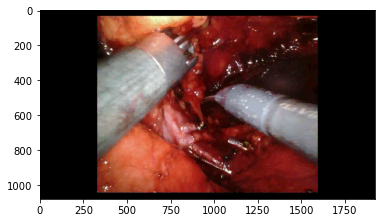

In [8]:
fig, OVERLAY = build_animators()

HTML('='*20+"> [  Tool Colormap:                                       "
           +cstr("Grasper", "red") +" | "+cstr("Bipolar", "yellow") +"  |  "+cstr("Hook", "blue")+"  |  "
           +cstr("Scissors", "violet")+"  |  " +cstr("Clipper", "orange") 
           +"  |  "+cstr("Irrigator", "mouve") +"  |  "+cstr("Specimen bag  ", "green")+'  ] <'+'='*20 )

<br> Let's track the instruments in the video<br>

In [12]:
anim = animation.ArtistAnimation(fig, OVERLAY, interval=160, blit=True, repeat_delay=1000)
HTML(anim.to_html5_video())

In [11]:
writervideo = animation.FFMpegWriter(fps=5)
f = 'data/output_RAPN.mp4'
anim.save(f, writer=writervideo)

End